In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_csv('Karan_data/dataset_1.csv', header=None, sep='\t');
data = data.values
X = data[:, 0:64]
y = data[:, 64]
# X = X[~np.all(X == 0.0, axis=1)].T          # remove all zero rows
print(X.shape)
print(y.shape)
print(np.unique(y))
# X = normalize(X)


(537, 64)
(537,)
[0. 1. 2.]


In [11]:
def normalize(X):
    X_norm = X.copy()
    for i in range(X.shape[1]):
        if(np.std(X[:, i]) != 0):
            X_norm[:, i] = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    return X_norm

In [12]:
class LDA():
    def __init__(self) -> None:
        pass

    def fit(self,X,y, n_components, type = 1):
        self.n_components = n_components
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.mean_vectors = []
        self.S_W = np.zeros((X.shape[1], X.shape[1]))
        self.S_B = np.zeros((X.shape[1], X.shape[1]))
        # S_W = np.cov(X.T)
        self.get_mean_vectors(X,y)
        self.get_sw(X, y, type)
        self.get_sb(X,y)
        
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(self.S_W).dot(self.S_B))
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs = sorted(eig_pairs, key=lambda x: x[0], reverse=True)
        self.w = np.hstack(list((eig_pairs[i][1].reshape(X.shape[1],1)) for i in range(self.n_components)))
        return self
    
    def get_mean_vectors(self,X,y):
        for i in range(self.n_classes):
            self.mean_vectors.append(np.mean(X[y==i], axis=0))

    def get_sw(self, X, y, type = 1):
        for i in range(self.n_classes):
            if(type == 1):
                self.S_W += np.cov(X[y==i].T)      #Covariance is a Feature*Feature matrix  
            else:
                for x in X[y==i]:
                    self.S_W += (x - self.mean_vectors[i]).reshape(X.shape[1],1).dot((x - self.mean_vectors[i]).reshape(X.shape[1],1).T) 

    def get_sb(self, X, y):
        for i in range(self.n_classes):
            n = X[y==i].shape[0]
            mean_diff = (self.mean_vectors[i] - np.mean(X, axis=0)).reshape(X.shape[1],1)
            self.S_B += n * (mean_diff).dot(mean_diff.T)


In [13]:
model = LDA()

model.fit(X,y,2)
X_lda = X.dot(model.w)
print(X_lda.shape)

model.fit(X,y,2,2)
X_lda1 = X.dot(model.w)


(537, 2)


In [14]:
class my_PCA():
    def __init__(self,n_components) -> None:
        self.n_components = n_components
        pass

    def fit(self,X):
        #sklearn PCA
        pca = PCA(n_components=self.n_components)
        pca.fit(X)
        self.w = pca.components_
        return self
    
    def transform(self, X):
        return X.dot(self.w)

In [15]:
model2 = PCA(n_components=2)
model2.fit(X)
X_pca = model2.transform(X)
print(X_pca.shape)

(537, 2)


/home/aytien/.local/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


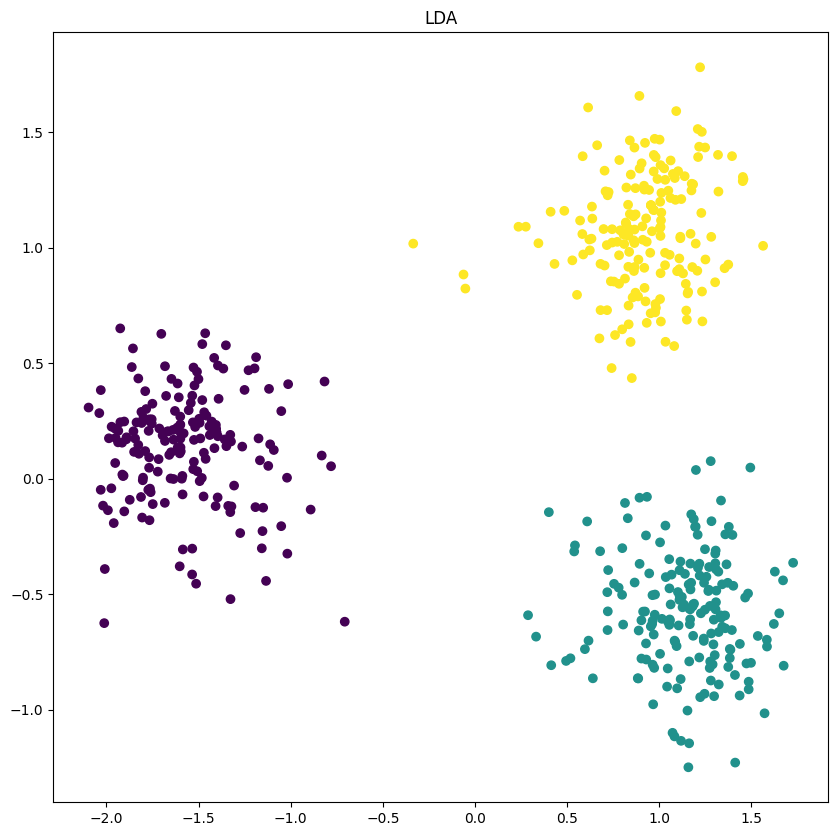

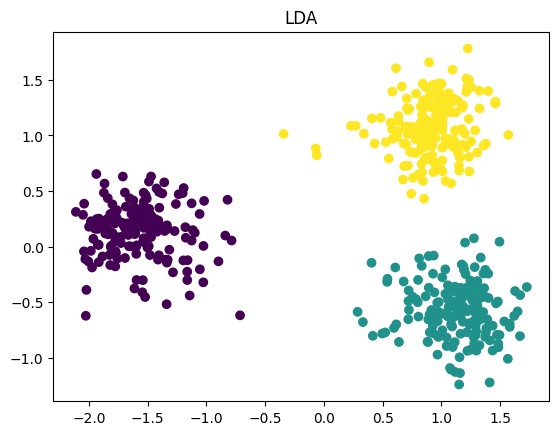

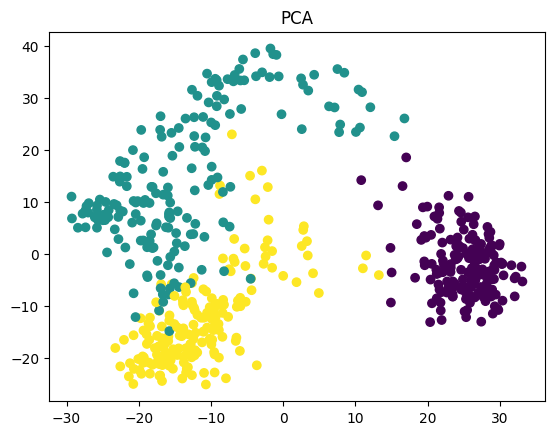

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(X_lda[:,0], X_lda[:,1], c=y)
plt.title('LDA')
plt.show()
plt.scatter(X_lda1[:,0], X_lda1[:,1], c=y)
plt.title('LDA')
plt.show()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('PCA')
plt.show()

In [ ]:
class naive_bayes:
    def __init__(self) -> None:
        self.mean = None
        self.std = None
        self.prior = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
    
    def fit(self, X, y):
        self.calculate_mean_std(X, y)
    
    def calculate_mean_std(self, X, y):
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.n_features = X.shape[1]
        self.mean = np.zeros((self.n_classes, self.n_features))
        self.std = np.zeros((self.n_classes, self.n_features))
        self.prior = np.zeros(self.n_classes)
        for i in range(self.n_classes):
            X_i = X[y == self.classes[i]]
            self.mean[i, :] = X_i.mean(axis=0)
            self.std[i, :] = X_i.std(axis=0)
            self.prior[i] = X_i.shape[0] / X.shape[0]
    
    def predict(self, X):
        y_pred = [self.predict_single(x) for x in X]
        return y_pred
    
    def predict_single(self, x):
        posteriors = []
        for i in range(self.n_classes):
            x1 = x - self.mean[i]
            prior = np.log(self.prior[i])
            posterior = np.dot(x1,x1)
            posterior = prior - (posterior/2)
            # posterior = np.exp(-np.dot(x1,x1)/2)*self.prior[i]
            posteriors.append(posterior)
        # print(posteriors)
        return self.classes[np.argmax(posteriors)]
    



In [ ]:
class QDA_bayes(naive_bayes):
    def __init__(self) -> None:
        super().__init__()
        self.n_cov = None
    
    def calculate_mean_cov(self, X, y):
        super().calculate_mean_std(X, y)
        self.n_cov = np.zeros((self.n_classes, self.n_features, self.n_features))
        for i in range(self.n_classes):
            X_i = X[y == self.classes[i]]
            self.n_cov[i] = np.cov(X_i.T)
            # mean = np.mean(X_i,axis = 0)
            # self.n_cov[i] = np.dot((X_i-mean).T,(X_i-mean))
            # self.n_cov[i] = 
            # self.n_cov[i] = (float(len(X_i))/float((len(X_i)-1)))*self.n_cov[i]
            # temp_cov = np.cov(X_i.T)
            # print(self.n_cov[i],temp_cov)
    
    def predict_single(self, x):
        posteriors = []
        for i in range(self.n_classes):
            x1 = x - self.mean[i]
            prior = np.log(self.prior[i])-np.log(np.linalg.det(self.n_cov[i]))/2
            posterior = np.dot(x1, np.dot(np.linalg.inv(self.n_cov[i]), x1))
            posterior = prior - (posterior/2)

            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def fit(self, X, y):
        self.calculate_mean_cov(X, y)

    def predict(self, X):
        y_pred = [self.predict_single(x) for x in X]
        return y_pred
    

In [21]:
#perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2)
#transfer to csv
np.savetxt("X_train.csv", X_train, delimiter=",")
np.savetxt("X_test.csv", X_test, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")